# Data Analysis

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

# I get this because of a copy warning using dataframes. More info is found here:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
# Ignoring all warnings is a horrible practice if you are running the code for the first time.
# However, upon further research I deemed the warning irrelevant, so I suppress it to make the output clean.
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Data Cleaning

In [2]:
def clean_data(df):
    
    #Time when Riot started adding timestamps
    beginning = 1623987436
    
    #Naming the columns
    df.columns = ["puuid", "match_id", "start_time", "duration"]

    #Drop duplicate values
    df.drop_duplicates(inplace=True)

    #Changing from milliseconds to seconds
    df["start_time_seconds"] = df["start_time"]/1000

    #Creating column of datetimes for the start time of games
    df["start_time_date"] = df["start_time_seconds"].apply(lambda x : datetime.datetime.fromtimestamp(int(x)))

    #Start time is measured in epoch time ms, so we convert to seconds
    df["start_time_seconds"] = df["start_time"]/1000
    
    #There are some games where the timestamps are messed up and start at 0, corresponding to 1970 (look up unix time)
    #So we remove these
    df = df[df["start_time_seconds"] > beginning]
    
    #duration is sometimes measured in seconds and sometimes in ms, so we conver to seconds via some condition
    df["duration_seconds"] = df["duration"].apply(lambda x : x/1000  if x/60 > 120 else x)

    #createa column for end_time since this is not tracked in all of the json files
    df["end_time_seconds"] = df["start_time_seconds"] + df["duration_seconds"]

    #Sort the values by start_time
    df.sort_values(by = "start_time_seconds", ascending=True, inplace=True, ignore_index=True)

    #Creating a new column which measures the time difference between the end of a game and the beginning of the next one
    del_t = []
    del_t.append(0)

    for i in range(1,len(df["start_time_seconds"])):

        del_t.append(df["start_time_seconds"][i] - df["end_time_seconds"][i-1])

    #In seconds
    df["del_t"] = del_t

    #Want the time between games in hours
    df["del_t_hours"] = df["del_t"]/(60*60)
    
    return(df)

# Frequency of Games Played for 10 LoL Players

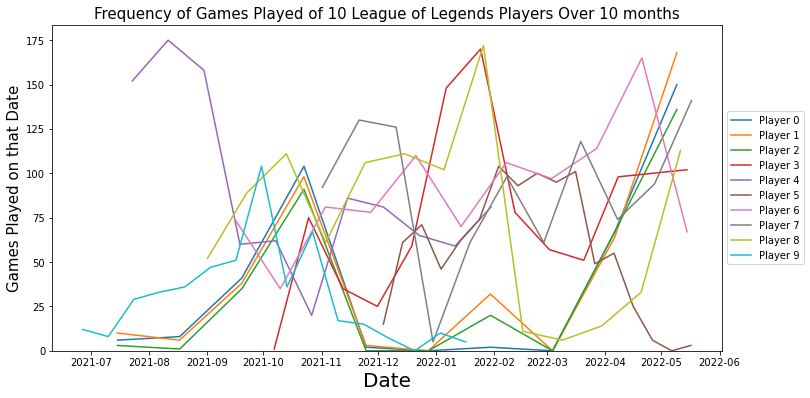

In [21]:
fig, ax = plt.subplots(figsize = (12,6))

c_list = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]

for i, filepath in enumerate(os.listdir("Player_Time_Data_2/")):
    
    df = pd.read_csv("Player_Time_Data_2/{}".format(filepath),
                      dtype='str,str,float,float', 
                      delimiter = " ",
                      usecols=(0,1,2,3),
                      header = None
                    )
    
    df = clean_data(df)
    
    sns.histplot(data = df["start_time_date"], 
                 element = 'poly', 
                 fill= False, 
                 ax = ax, 
                 ls = "solid", 
                 color = c_list[i],
                 label = "Player {}".format(i),
                )
    
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Games Played on that Date", fontsize = 15)
plt.title("Frequency of Games Played of 10 League of Legends Players Over 10 months", fontsize = 15)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    

This graph represents how many times a summoner played a game at a certain date. There doesn't appear to be any evident pattern, but if you notice players 0,1,2 their play frequencies seem to align pretty well. I looked them up and turns out they queue up together fairly often.

Graphs like this lose any sort of valuable information the more summoners there are in the plot. So let's check out some other ways to visually explore the data.

# Time Between Games Played for one LoL Player

In [10]:
df = pd.read_csv("Player_Time_Data_2/player_0_times.txt",
                      dtype='str,str,float,float', 
                      delimiter = " ",
                      usecols=(0,1,2,3),
                      header = None
                    )
    
df = clean_data(df)

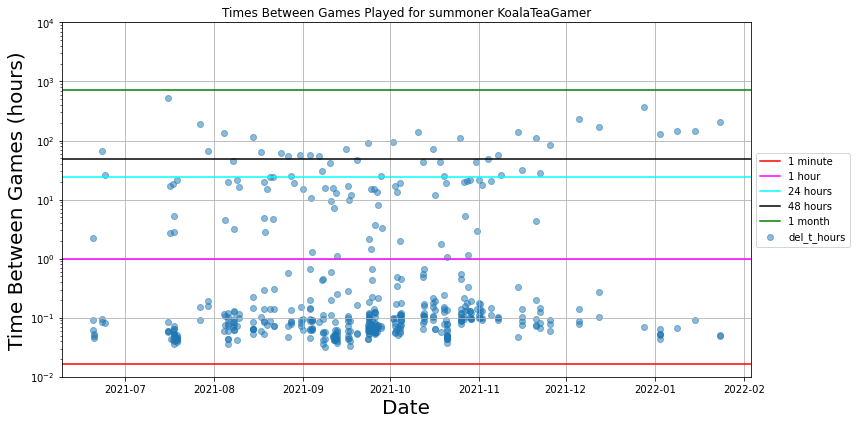

In [18]:
fig, ax = plt.subplots(figsize = (12,6))

ax.scatter(x = "start_time_date", y = "del_t_hours", data = df, alpha = .5)

ax.axhline(y = 1/60,   c = "red",     label = "1 minute")
ax.axhline(y = 1,      c = "magenta", label = "1 hour")
ax.axhline(y = 24,     c = "cyan",    label = "24 hours")
ax.axhline(y = 48,     c = "black",   label = "48 hours")
ax.axhline(y = 24*30,  c = "green",   label = "1 month")


ax.set_yscale("log")
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Time Between Games (hours)", fontsize = 20)


from riotwatcher import LolWatcher


watcher = LolWatcher(api_key="RGAPI-6be672f9-c05f-4c34-8648-24efbc288758")
summoner_name = watcher.summoner.by_puuid('na1',df["puuid"][0])["name"]
plt.title("Times Between Games Played for summoner {}".format(summoner_name))


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
#plt.xlim(datetime.datetime.fromtimestamp(1632385853), datetime.datetime.fromtimestamp(1632817853))
plt.ylim(.01,10000)
plt.tight_layout()

In the plot above, on the x-axis is the start time of a game in terms of the date. On the y-axis is the time between the start of that game and the end of the previous game, $\Delta t$. This is the key metric we wish to analyze as it determines if a player almost churned: if $\Delta t$ is very large, it means it's the first time a summoner played a game in a long period of time.

In the graph abobve, there is a point near 07/2021 where the player hadn't played in almost a month. Let's take a look at this type of plot for many players.

# Time Between Games Played for 10 LoL Players

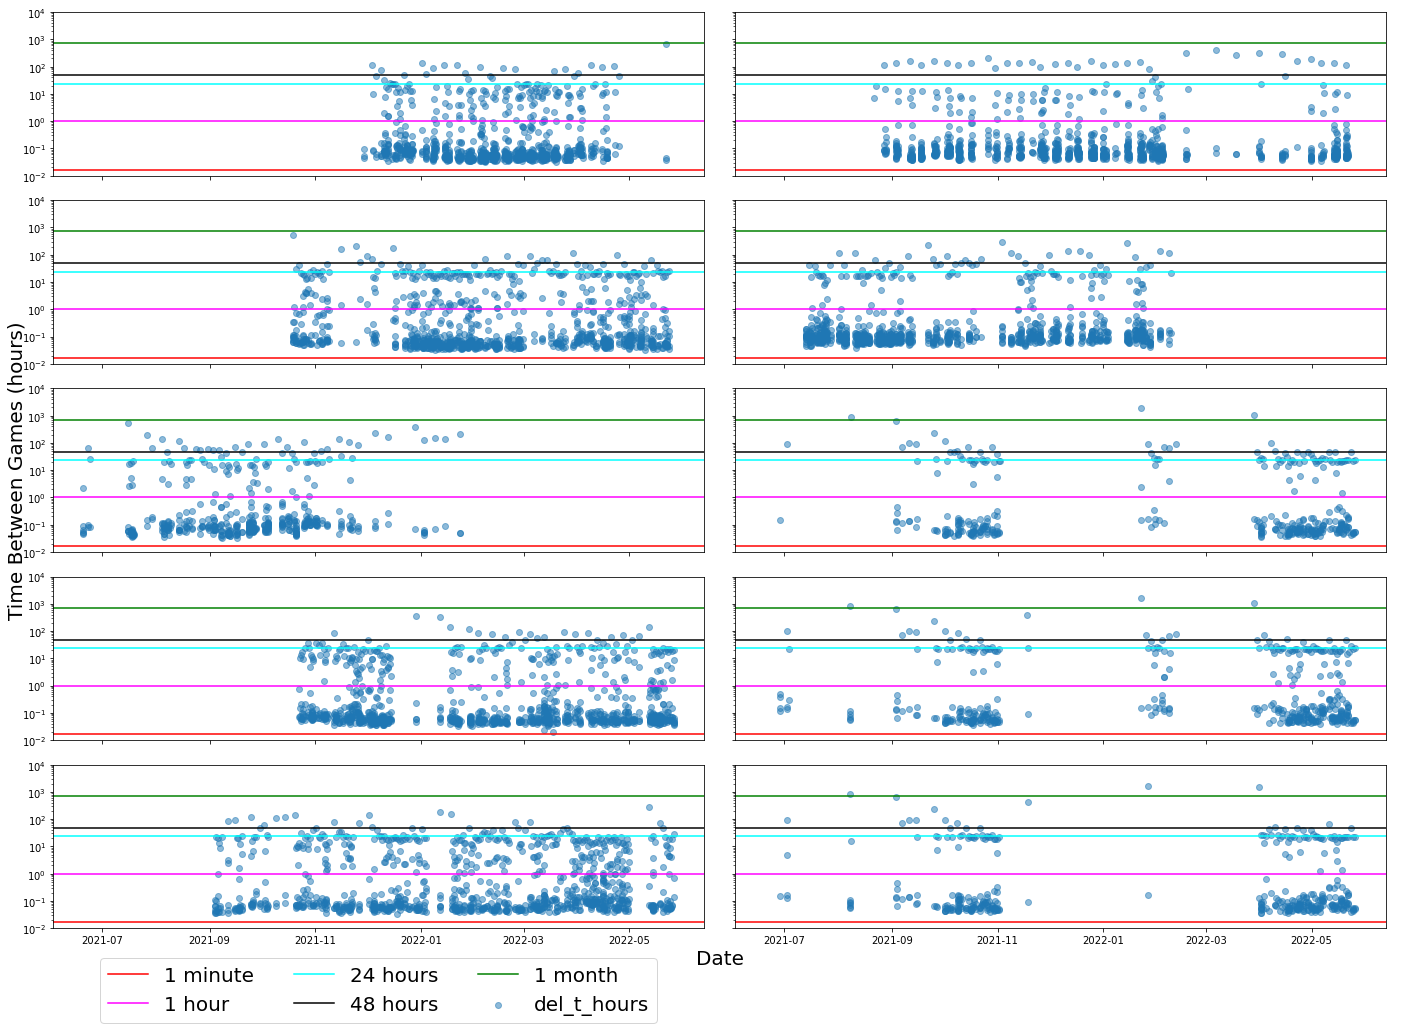

In [6]:
fig, axes = plt.subplots(nrows = 5, 
                       ncols=2, 
                       figsize = (20,15), 
                       sharex=True, 
                       sharey=True)


axis_list = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1),(3,0),(3,1),(4,0),(4,1)]

for i, filepath in enumerate(os.listdir("Player_Time_Data_2/")):
    
    df = pd.read_csv("Player_Time_Data_2/{}".format(filepath),
                      dtype='str,str,float,float', 
                      delimiter = " ",
                      usecols=(0,1,2,3),
                      header = None
                    )
    
    df = clean_data(df)
    
    axes[axis_list[i]].scatter(x = "start_time_date", y = "del_t_hours", data = df, alpha = .5)
    
    
    axes[axis_list[i]].axhline(y = 1/60,c = "red", label = "1 minute")
    axes[axis_list[i]].axhline(y = 1,   c = "magenta", label = "1 hour")
    axes[axis_list[i]].axhline(y = 24,  c = "cyan", label = "24 hours")
    axes[axis_list[i]].axhline(y = 48,  c = "black", label = "48 hours")
    axes[axis_list[i]].axhline(y = 24*30,  c = "green", label = "1 month")
    
    axes[axis_list[i]].set_yscale("log")
    
    #plt.xlabel("Date", fontsize = 20)
    #plt.ylabel("Hours Between Games", fontsize = 20)
    #plt.grid()
    plt.ylim(.01,10000)

    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Time Between Games (hours)", fontsize = 20)
  
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
axes.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, prop={'size': 20})    


plt.tight_layout()

There are a few summoners who almost churned, represented by large gaps in points within a plot. In fact the same 3 players were the ones tha almost churned as they had 2 instances where more than a month passed by since they played their last game.

One player actually churned completely, shown in plot (1,1).

# Many Summoners' Data Analysis

Ok, so we explored a bit an individual summoner's game trends, and a group of 10 summoners' game trends. How do we explore data of many many summoners?

There isn't any good way to visualize $\Delta t$ for many players except by aggregating by the date. So let's do that and explore.